## Comparison of clij2-fft with gpu_rl_deconv by James Manton


I don't think the gpu_rl_deconv code extends the image borders.  For that reason there may be artifacts at high iterations.

It seems the code adds random noise to the PSF [see](https://github.com/jdmanton/gpu_rl_deconv/blob/master/gpu_deconv.py#L30).  I wonder if this was done to avoid the ringing artifacts that can occur with PSF of different size compared to image. 

When image is extended we can think of it being equivalent to extending our 'solution space'.  Then the acquired image has been multiplied by a window w in the larger space.  And the RL equation becomes.

$$
    {o}_{k+1} = \frac{o_{k}\left[\frac{wi}{o_{k}*h}*h^*\right]}{n}
$$

Where ```n``` is a normalization factor calculated as ```HTones```.  The ```H``` operator on the image is convolution followed by multiplication by a window

$$
measuredimage=w(h*reality)
$$

So ```HTones``` would by

$$
(w(ones))*h^*
$$



(50, 256, 256)


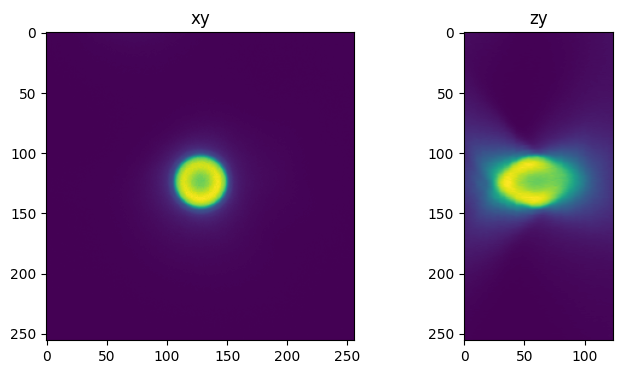

In [1]:
from skimage.io import imread
import numpy as np
from tnia.plotting.projections import show_xy_zy_slice

path_=r"D:\images\tnia-python-images\deconvolution\bead"

bead=imread(path_+"/Bead.tif")
z_start=75
z_end=125
z_to_view=(z_end-z_start)//2

roi=np.s_[z_start:z_end, :, :]
bead=bead[roi]
bead=bead[::-1,:,:]

xy_spacing = 0.0645
z_spacing=.16

ratio = z_spacing/xy_spacing

print(bead.shape)

fig=show_xy_zy_slice(bead,128,128,z_to_view, sz=ratio, figsize=(8,4))

sdeconv 1.x.x detected
sdeconv 1.x.x detected
sdeconv 1.x.x detected
sdeconv 1.x.x detected
sdeconv 1.x.x detected
sdeconv 1.x.x detected


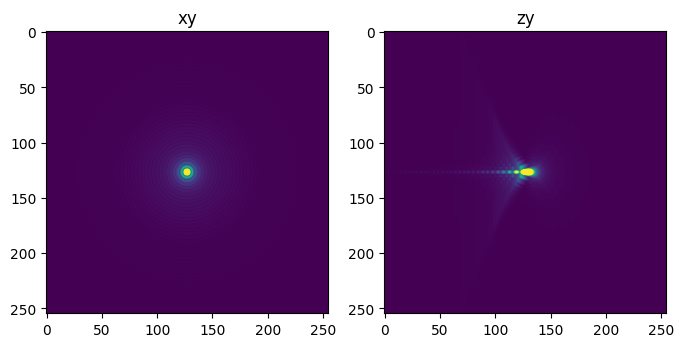

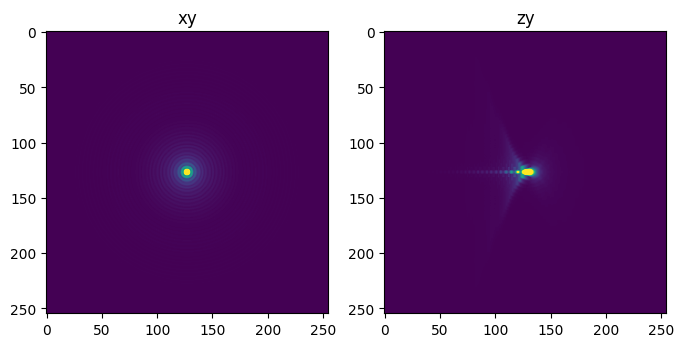

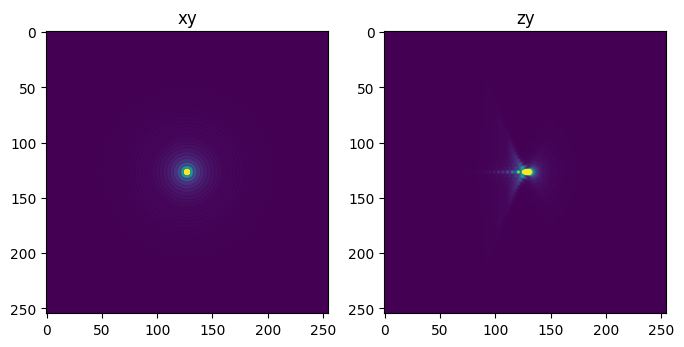

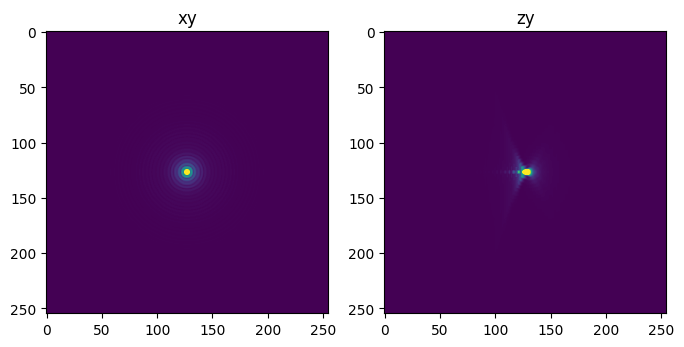

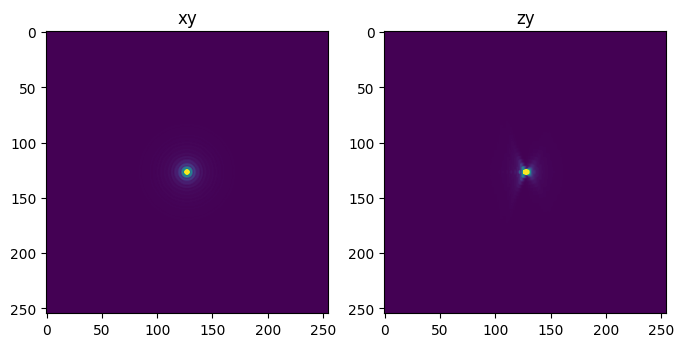

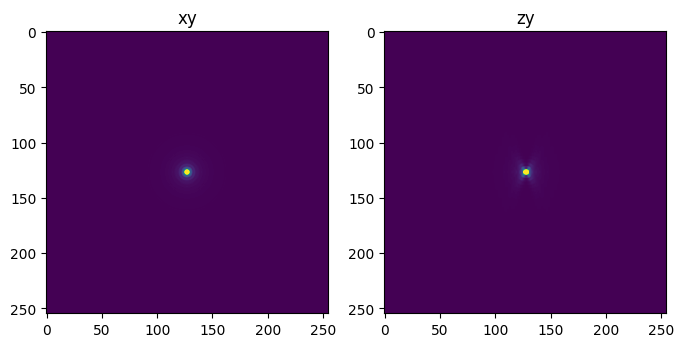

In [2]:
from tnia.nd.ndutil import centercrop
from tnia.deconvolution.psfs import gibson_lanni_3D
from tnia.plotting.projections import show_xy_zy_max
from tnia.deconvolution.psfs import recenter_psf_axial
from skimage.io import imsave

ni=1.518
ns_to_test=[1.42,1.44,1.46,1.48,1.50,1.518]
NA=1.4
w=0.530

xy_spacing = 0.0645
z_spacing=.16

xy_psf_dim=255
z_compute_psf_dim=599
z_crop_psf_dim=101

#depth to compute PSF at
d=128*z_spacing

psfs=[]
for ns in ns_to_test:

    psf  = gibson_lanni_3D(NA, ni, ns, xy_spacing, z_spacing, xy_psf_dim, z_compute_psf_dim, d, w)
    psf = psf.astype('float32')

    #fig=show_xy_zy_max(psf, vmax=psf.max())
    psf=recenter_psf_axial(psf, 255)
    #psf,labels=recenter_psf_axial(psf, 255, return_labels=True)
    #fig=show_xy_zy_max(labels)
    fig=show_xy_zy_max(psf, vmax=psf.max()/4, figsize=(8,4))
    psfs.append(psf)
    
#imsave(path_+"/PSF-SA.tif", psf)

testing ns=1.42
get lib
Input shape: (50, 256, 256)
PSF shape: (50, 255, 255)
Number of iterations: 2000
PSF processing: False

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110 1120 1130 1140 1150 1160 1170 1180 1190 1200 1210 1220 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 1480 1490 1500 1510 1520 1530 1540 1550 1560 1570 1580 1590 1600 1610 1620 1630 1640 1650 1660 1670 1680 1690 1700 1710 1720 1730 1740 1750 1760 1770 1780 1790 1800 1810 1820 1830 1840 1850 1860 1870 1880 1890 1900 1910 1920 1930 1940 1950 196

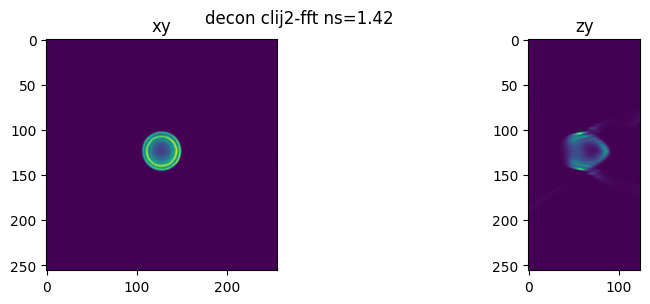

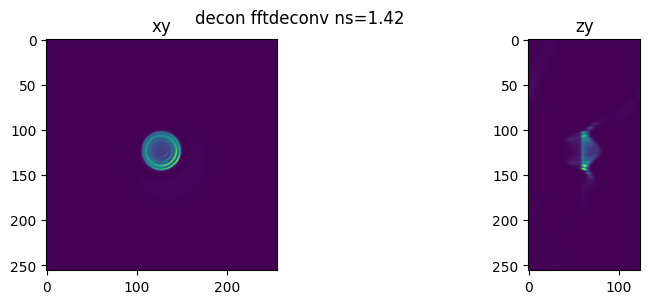

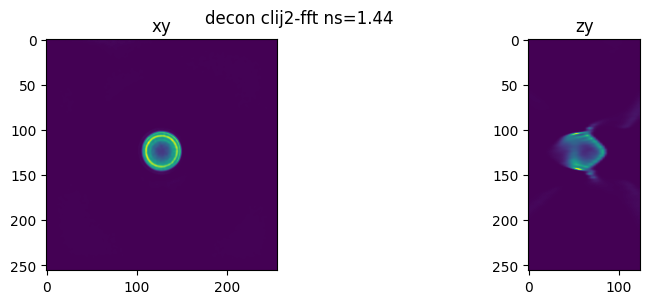

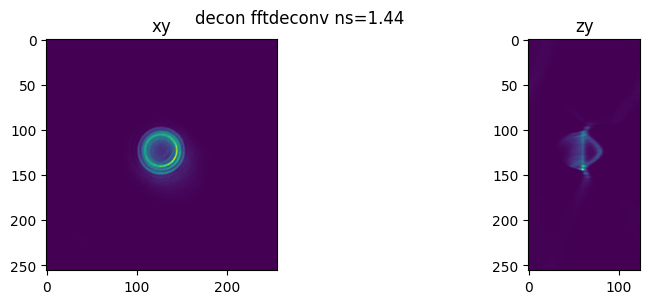

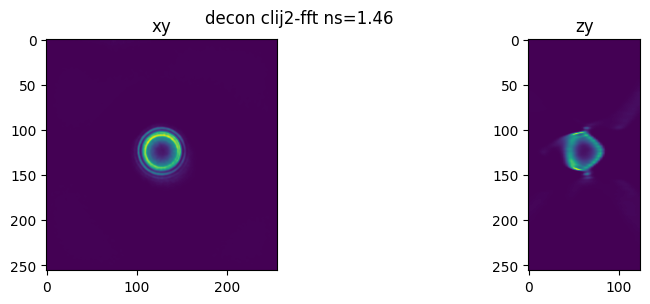

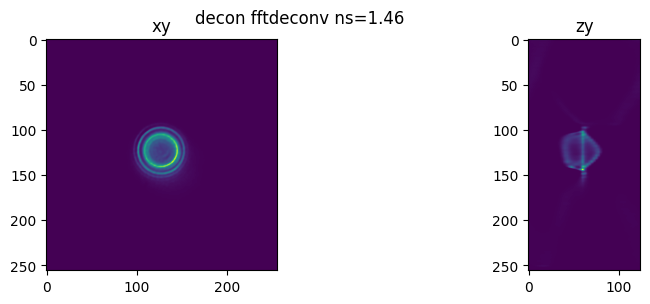

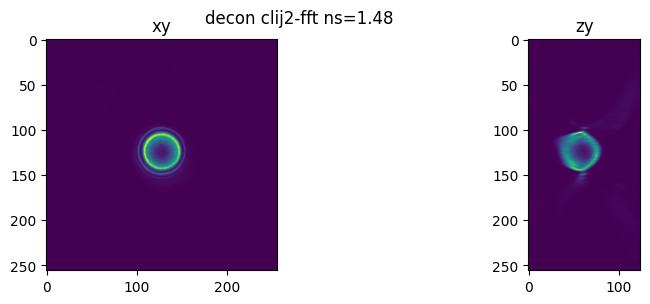

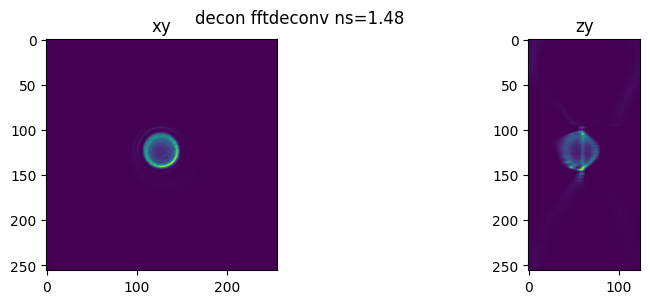

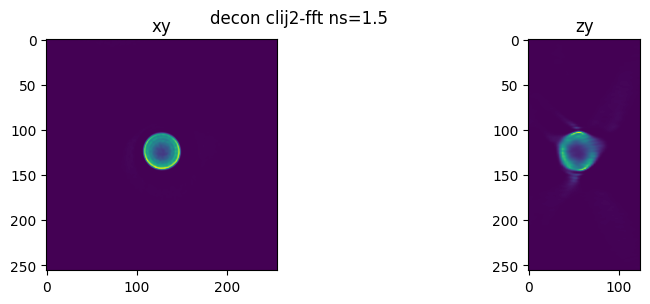

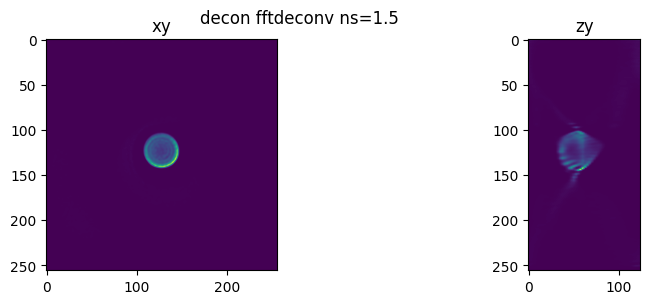

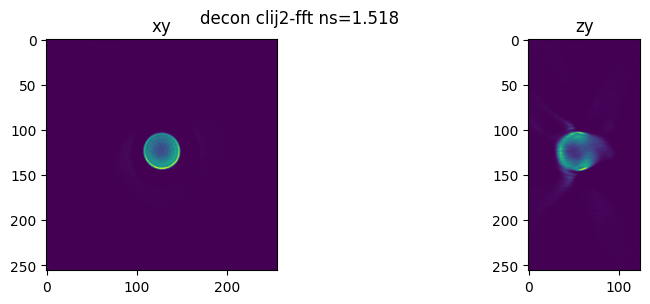

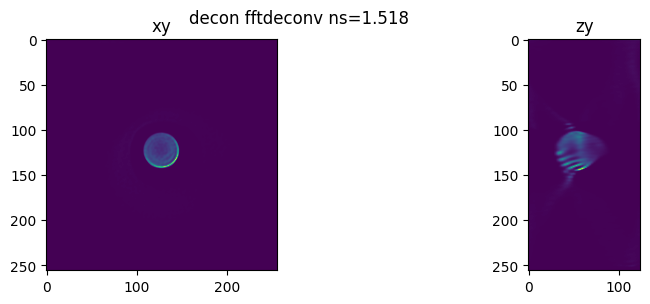

In [4]:
from clij2fft.richardson_lucy import richardson_lucy_nc
from tnia.deconvolution.fftdeconv import fftdeconv 

regularization_factor=0
decons=[]
decons_manton=[]

iterations=2000

for psf, ns in zip(psfs,ns_to_test):
    print('testing ns='+str(ns))
    im_decon = richardson_lucy_nc(bead, psf, 2000, regularization_factor)
    psf=centercrop(psf, (bead.shape[0], psf.shape[1], psf.shape[2]))
    im_decon_m = fftdeconv(bead, psf, 2000)
    decons.append(im_decon)
    decons_manton.append(im_decon_m)
    fig=show_xy_zy_slice(im_decon,128,128,z_to_view, sz=ratio)
    fig.suptitle('decon clij2-fft ns='+str(ns))
    fig=show_xy_zy_slice(im_decon_m,128,128,z_to_view, sz=ratio)
    fig.suptitle('decon fftdeconv ns='+str(ns))

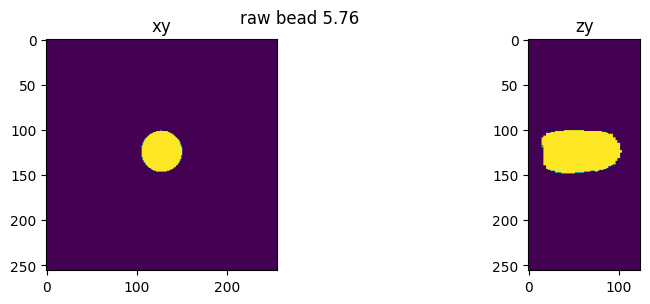

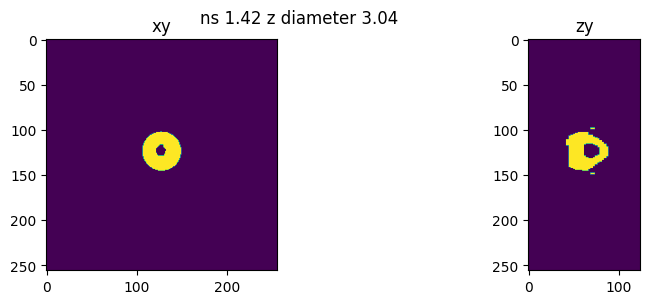

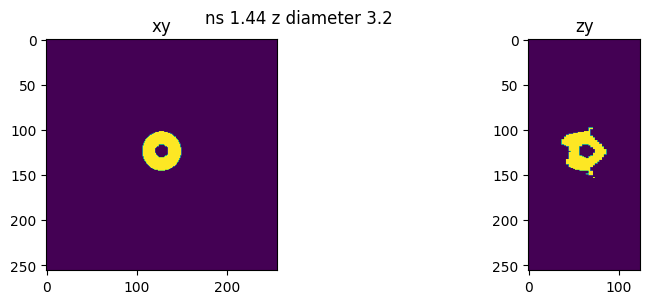

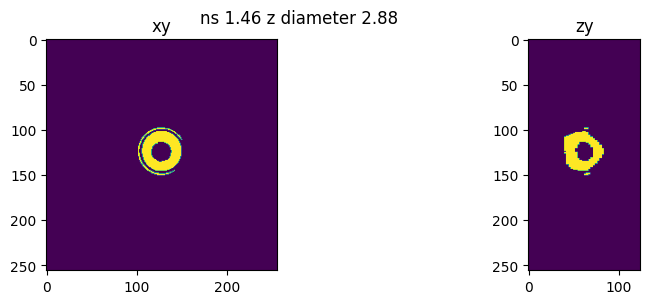

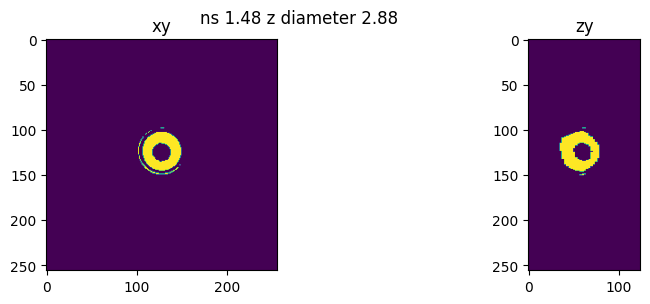

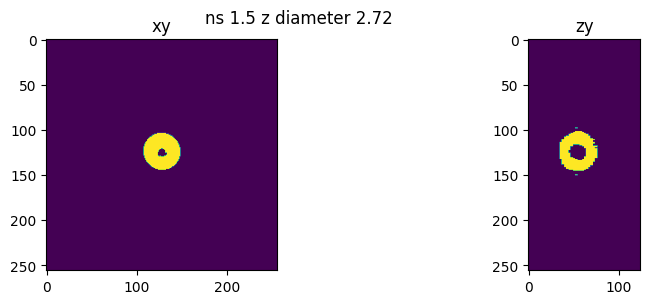

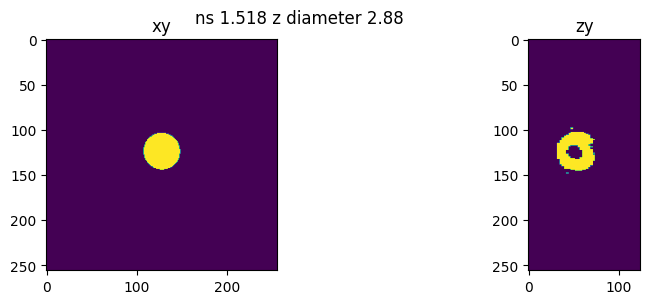

In [11]:
from skimage.filters import threshold_otsu
from skimage.measure import label
from skimage.measure import regionprops

bead_thresholded=bead>threshold_otsu(bead)
fig=show_xy_zy_slice(bead_thresholded,128,128,z_to_view, sz=z_spacing/xy_spacing)
bead_labeled=label(bead_thresholded)
bead_objects=regionprops(bead_labeled)
o = bead_objects[0]
fig.suptitle("raw bead "+str((o.bbox[3]-o.bbox[0])*z_spacing))

for decon, ns in zip(decons,ns_to_test):
    decon_thresholded=decon>threshold_otsu(im_decon)

    fig=show_xy_zy_slice(decon_thresholded,128,128,z_to_view, sz=z_spacing/xy_spacing)
    decon_labeled=label(decon_thresholded)

    decon_objects=regionprops(decon_labeled)
    o = decon_objects[0]
    fig.suptitle("ns "+str(ns)+' z diameter '+str((o.bbox[3]-o.bbox[0])*z_spacing))


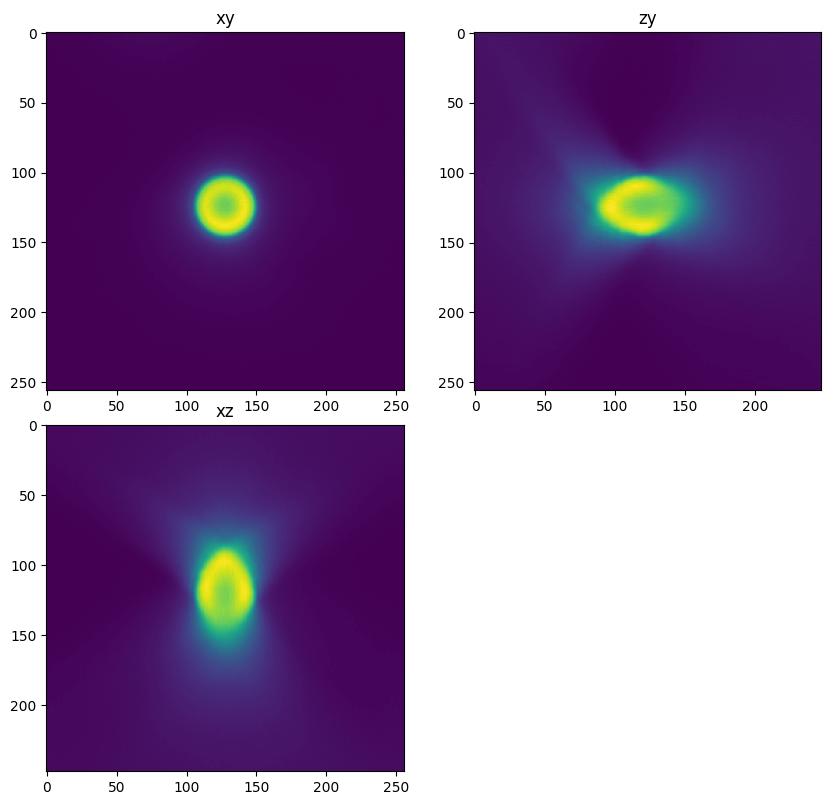

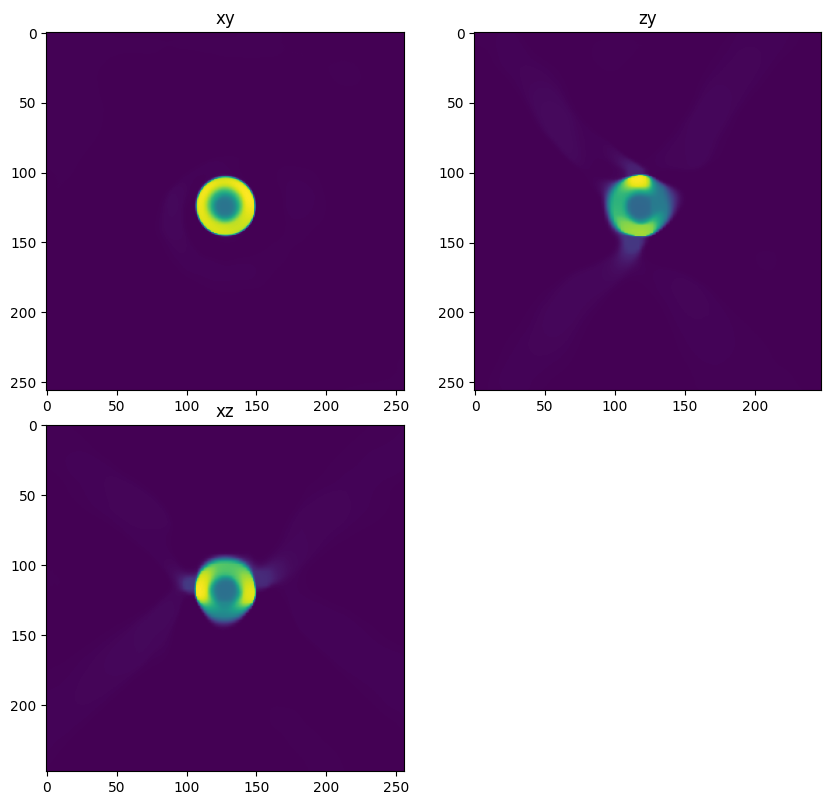

In [142]:
fig=show_xyz_slice(bead,128,128,50, sz=z_spacing/xy_spacing)
fig=show_xyz_slice(im_decon,128,128,50, sz=z_spacing/xy_spacing)


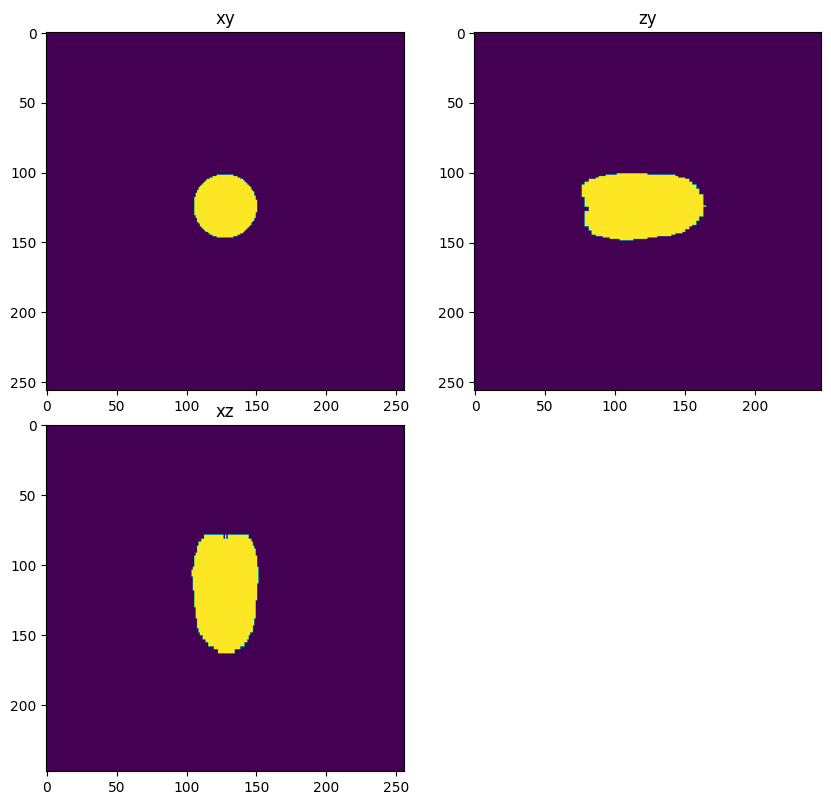

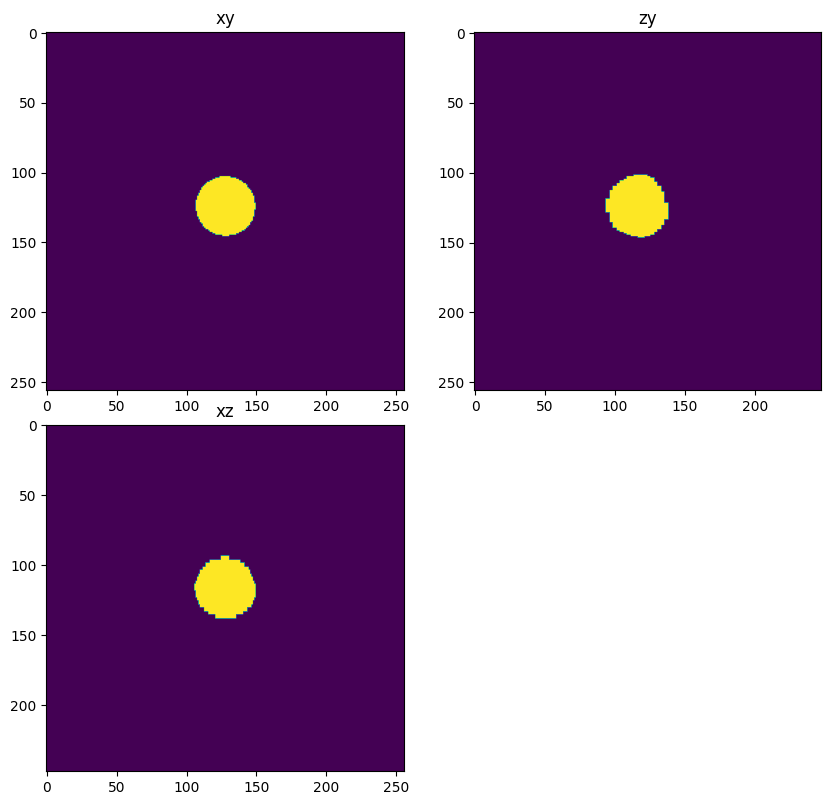

In [136]:
from skimage.filters import threshold_otsu
bead_thresholded=bead>threshold_otsu(bead)
decon_thresholded=im_decon>threshold_otsu(im_decon)

fig=show_xyz_slice(bead_thresholded,128,128,z_to_view, sz=z_spacing/xy_spacing)
fig=show_xyz_slice(decon_thresholded,128,128,z_to_view, sz=z_spacing/xy_spacing)

In [143]:
import napari
viewer=napari.Viewer()

viewer.add_image(bead, scale=(z_spacing/xy_spacing,1,1))
viewer.add_image(im_decon, scale=(z_spacing/xy_spacing,1,1))

<Image layer 'im_decon' at 0x20f63b1cd00>

In [137]:
from skimage.measure import label
bead_labeled=label(bead_thresholded)
decon_labeled=label(decon_thresholded)



In [138]:
from skimage.measure import regionprops

bead_objects=regionprops(bead_labeled)

for o in bead_objects:
    print((o.bbox[3]-o.bbox[0])*z_spacing)
    print((o.bbox[4]-o.bbox[1])*xy_spacing)
    print((o.bbox[5]-o.bbox[2])*xy_spacing)
    
decon_objects=regionprops(decon_labeled)

for o in decon_objects:
    print((o.bbox[3]-o.bbox[0])*z_spacing)
    print((o.bbox[4]-o.bbox[1])*xy_spacing)
    print((o.bbox[5]-o.bbox[2])*xy_spacing)
    

5.76
3.096
3.1605
2.88
2.9025
2.838


In [73]:
len(psfs)

6

get lib
Input shape: (50, 256, 256)
PSF shape: (50, 255, 255)
Number of iterations: 500
PSF processing: False

Iteration 1 completed in 0.001106 s.
Iteration 2 completed in 0.001041 s.
Iteration 3 completed in 0.000981 s.
Iteration 4 completed in 0.000977 s.
Iteration 5 completed in 0.001002 s.
Iteration 6 completed in 0.000973 s.
Iteration 7 completed in 0.000968 s.
Iteration 8 completed in 0.000969 s.
Iteration 9 completed in 0.001063 s.
Iteration 10 completed in 0.000550 s.
Iteration 11 completed in 0.000395 s.
Iteration 12 completed in 0.000397 s.
Iteration 13 completed in 0.000398 s.
Iteration 14 completed in 0.000466 s.
Iteration 15 completed in 0.000406 s.
Iteration 16 completed in 0.000388 s.
Iteration 17 completed in 0.000418 s.
Iteration 18 completed in 0.000390 s.
Iteration 19 completed in 0.000388 s.
Iteration 20 completed in 0.000381 s.
Iteration 21 completed in 0.000418 s.
Iteration 22 completed in 0.000395 s.
Iteration 23 completed in 0.000397 s.
Iteration 24 completed i

Text(0.5, 0.98, 'decon manton')

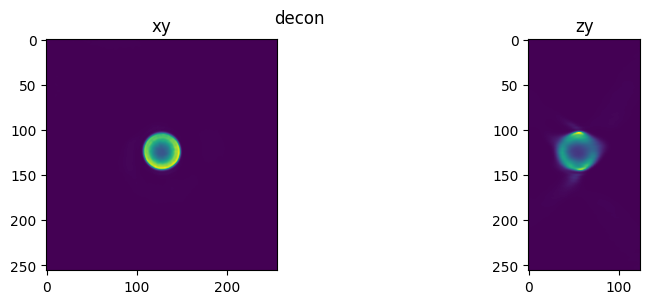

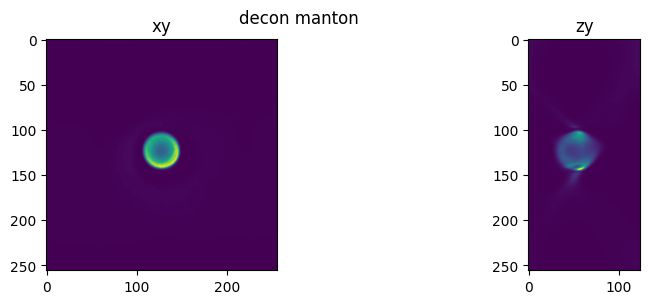

In [6]:

from clij2fft.richardson_lucy import richardson_lucy_nc
from tnia.deconvolution.rl_manton import fftdeconv 
regularization_factor=0.0

psf=psfs[4]
im_decon = richardson_lucy_nc(bead, psf, 500, regularization_factor)
psf=centercrop(psf, (bead.shape[0], psf.shape[1], psf.shape[2]))
im_decon_m = fftdeconv(bead, psf, 500)
fig=show_xy_zy_slice(im_decon,128,128,z_to_view, sz=ratio)
fig.suptitle('decon')
fig=show_xy_zy_slice(im_decon_m,128,128,z_to_view, sz=ratio)
fig.suptitle('decon manton')

In [75]:


decon.shape

(100, 256, 256)

In [12]:
save_path=r"D:\images\tnia-python-images\deconvolution\bead"
from skimage.io import imsave
imsave(save_path+"\\bead-2.5um.tif", bead)
imsave(save_path+"\\bead-2.5um-decon-python.tif", im_decon)


C:\Users\bnort\AppData\Local\Temp\ipykernel_20576\3270661809.py:3: UserWarning: D:\images\tnia-python-images\deconvolution\bead\bead-2.5um.tif is a low contrast image
  imsave(save_path+"\\bead-2.5um.tif", bead)


In [7]:
bead=bead[::-1,:,:]

In [11]:

im_decon=im_decon[::-1,:,:]

In [13]:

save_path=r"D:\images\tnia-python-images\deconvolution\bead"
from skimage.io import imsave
imsave(save_path+"\\bead-2.5um.tif", bead)
imsave(save_path+"\\bead-2.5um-decon-python.tif", im_decon)